# Tutorial: Introductory Tutorial:  Physics Informed Neural Networks with PINA 
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mathLab/PINA/blob/master/tutorials/tutorial1/tutorial.ipynb)

> ##### ⚠️ ***Before starting:***
> We assume you are already familiar with the concepts covered in the [Getting started with PINA](https://mathlab.github.io/PINA/_tutorial.html#getting-started-with-pina) tutorials. If not, we strongly recommend reviewing them before exploring this advanced topic.


In this tutorial, we will demonstrate a typical use case of **PINA** for Physics Informed Neural Network (PINN) training. We will cover the basics of training a PINN with PINA, if you want to go further into PINNs look at our dedicated [tutorials](https://mathlab.github.io/PINA/_tutorial.html#physics-informed-neural-networks) on the topic.

Let's start by importing the useful modules:

In [ ]:
## routine needed to run the notebook on Google Colab
try:
    import google.colab

    IN_COLAB = True
except:
    IN_COLAB = False
if IN_COLAB:
    !pip install "pina-mathlab[tutorial]"

import warnings
import torch
import matplotlib.pyplot as plt

from pina import Trainer, Condition
from pina.problem import SpatialProblem
from pina.operator import grad
from pina.solver import PINN
from pina.model import FeedForward
from pina.optim import TorchOptimizer
from pina.domain import CartesianDomain
from pina.callback import MetricTracker
from pina.equation import Equation, FixedValue

warnings.filterwarnings("ignore")

## Build the problem

We will use a simple Ordinary Differential Equation as pedagogical example:

$$
\begin{equation}
\begin{cases}
\frac{d}{dx}u(x) &=  u(x) \quad x\in(0,1)\\
u(x=0) &= 1 \\
\end{cases}
\end{equation}
$$

with the analytical solution $u(x) = e^x$. 

The PINA problem is easly written as:

In [2]:
def ode_equation(input_, output_):
    u_x = grad(output_, input_, components=["u"], d=["x"])
    u = output_.extract(["u"])
    return u_x - u


class SimpleODE(SpatialProblem):

    output_variables = ["u"]
    spatial_domain = CartesianDomain({"x": [0, 1]})

    domains = {
        "x0": CartesianDomain({"x": 0.0}),
        "D": CartesianDomain({"x": [0, 1]}),
    }

    conditions = {
        "bound_cond": Condition(domain="x0", equation=FixedValue(1.0)),
        "phys_cond": Condition(domain="D", equation=Equation(ode_equation)),
    }

    def solution(self, pts):
        return torch.exp(pts.extract(["x"]))


problem = SimpleODE()

We are going to use latin hypercube points for sampling. We need to sample in all the conditions domains. In our case we sample in domain `D` and `x0`:

In [3]:
# sampling for training
problem.discretise_domain(1, "lh", domains=["x0"])
problem.discretise_domain(20, "lh", domains=["D"])

## Generate data 

Data for training can come in form of direct numerical simulation results, or points in the domains. In case we perform unsupervised learning, we just need the collocation points for training, i.e. points where we want to evaluate the neural network. Sampling point in **PINA** is very easy, here we show three examples using the `.discretise_domain` method of the `AbstractProblem` class.

In [4]:
# sampling 20 points in [0, 1] through discretization in all locations
problem.discretise_domain(n=20, mode="grid", domains="all")

# sampling 20 points in (0, 1) through latin hypercube sampling in D, and 1 point in x0
problem.discretise_domain(n=20, mode="latin", domains=["D"])
problem.discretise_domain(n=1, mode="random", domains=["x0"])

# sampling 20 points in (0, 1) randomly
problem.discretise_domain(n=20, mode="random")

We are going to use latin hypercube points for sampling. We need to sample in all the conditions domains. In our case we sample in `D` and `x0`.

In [5]:
# sampling for training
problem.discretise_domain(1, "random", domains=["x0"])
problem.discretise_domain(20, "lh", domains=["D"])

To visualize the sampled points we can use `matplotlib.pyplot`:

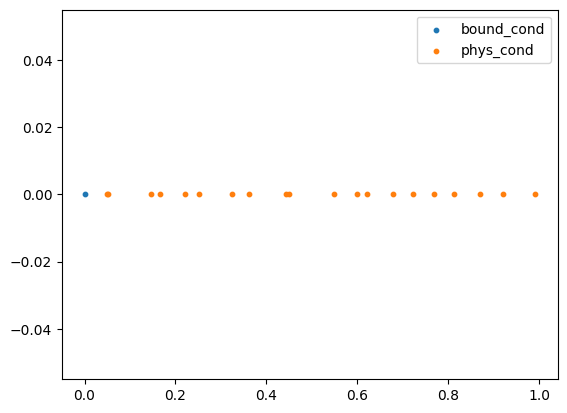

In [6]:
for location in problem.input_pts:
    coords = (
        problem.input_pts[location].extract(problem.spatial_variables).flatten()
    )
    plt.scatter(coords, torch.zeros_like(coords), s=10, label=location)
_ = plt.legend()

## Easily solve a Physics Problem with three step pipeline

Once the problem is defined and the data is generated, we can move on to modeling. This process consists of three key steps:

**Choosing a Model**
- Select a neural network architecture. You can use the model we provide in the `pina.model` module (see [here](https://mathlab.github.io/PINA/_rst/_code.html#models) for a full list), or define a custom PyTorch module (more on this [here](https://pytorch.org/docs/stable/notes/modules.html)).

**Choosing a PINN Solver & Defining the Trainer**
* Use a Physics Informed solver from `pina.solver` module to solve the problem using the specified model. We have already implemented most State-Of-The-Arte solvers for you, [have a look](https://mathlab.github.io/PINA/_rst/_code.html#solvers) if interested. Today we will use the standard `PINN` solver.

**Training**
* Train the model with the [`Trainer`](https://mathlab.github.io/PINA/_rst/trainer.html) class. The Trainer class provides powerful features to enhance model accuracy, optimize training time and memory, and simplify logging and visualization, thanks to PyTorch Lightning's excellent work, see [our dedicated tutorial](https://mathlab.github.io/PINA/tutorial11/tutorial.html) for further details. By default, training metrics (e.g., MSE error) are logged using a lightning logger (CSVLogger). If you prefer manual tracking, use `pina.callback.MetricTracker`.

Let's cover all steps one by one!

First we build the model, in this case a FeedForward neural network, with two layers of size 10 and hyperbolic tangent activation:

In [7]:
# build the model
model = FeedForward(
    layers=[10, 10],
    func=torch.nn.Tanh,
    output_dimensions=len(problem.output_variables),
    input_dimensions=len(problem.input_variables),
)

Then we build the solver. The Physics-Informed Neural Network (`PINN`) solver class needs to be initialised with a `model` and a specific `problem` to be solved. They also take extra arguments, as the optimizer, scheduler, loss type and weighting for the different conditions which are all set to their defualt values.

>##### 💡***Bonus tip:***
> All physics solvers in PINA can handle both forward and inverse problems without requiring any changes to the model or solver structure! See [our tutorial](https://mathlab.github.io/PINA/tutorial7/tutorial.html) of inverse problems for more infos.

In [8]:
# create the PINN object with RAdam Optimizer, notice that Optimizer need to
# be wrapped with the pina.optim.TorchOptimizer class
pinn = PINN(problem, model, TorchOptimizer(torch.optim.RAdam, lr=0.005))

Finally, we train the model using the Trainer API. The trainer offers various options to customize your training, refer to the official documentation for details. Here, we highlight the `MetricTracker` from `pina.callback`, which helps track metrics during training. In order to train just call the `.train()` method.

> ##### ⚠️ ***Important Note:***
> In PINA you can log metrics in different ways. The simplest approach is to use the `MetricTraker` class from `pina.callbacks` as we will see today. However, expecially when we need to train multiple times to get an average of the loss across multiple runs, we suggest to use `lightning.pytorch.loggers` (see [here](https://lightning.ai/docs/pytorch/stable/extensions/logging.html) for reference).


In [9]:
# create the trainer
trainer = Trainer(
    solver=pinn,  # The PINN solver to be used for training
    max_epochs=1500,  # Maximum number of training epochs
    logger=True,  # Enables logging (default logger is CSVLogger)
    callbacks=[MetricTracker()],  # Tracks training metrics using MetricTracker
    accelerator="cpu",  # Specifies the computing device ("cpu", "gpu", ...)
    train_size=1.0,  # Fraction of the dataset used for training (100%)
    test_size=0.0,  # Fraction of the dataset used for testing (0%)
    val_size=0.0,  # Fraction of the dataset used for validation (0%)
    enable_model_summary=False,  # Disables model summary printing
)

# train
trainer.train()

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1500` reached.


After the training we can inspect trainer logged metrics (by default **PINA** logs mean square error residual loss). The logged metrics can be accessed online using one of the `Lightning` loggers. The final loss can be accessed by `trainer.logged_metrics`

In [10]:
# inspecting final loss
trainer.logged_metrics

{'bound_cond_loss': tensor(8.7332e-08),
 'phys_cond_loss': tensor(4.1401e-05),
 'train_loss': tensor(4.1489e-05)}

By using `matplotlib` we can also do some qualitative plots of the solution. 

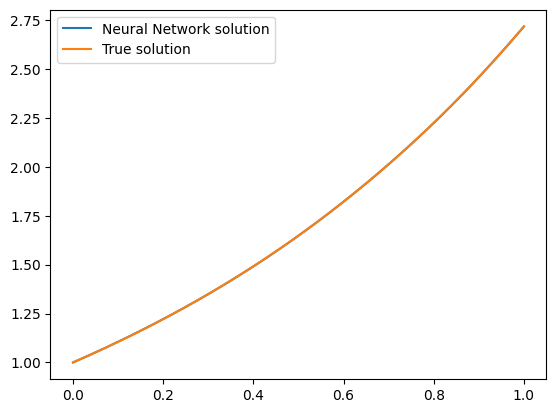

In [11]:
pts = pinn.problem.spatial_domain.sample(256, "grid", variables="x")
predicted_output = pinn.forward(pts).extract("u").tensor.detach()
true_output = pinn.problem.solution(pts).detach()
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(pts.extract(["x"]), predicted_output, label="Neural Network solution")
ax.plot(pts.extract(["x"]), true_output, label="True solution")
_ = plt.legend()

The solution is overlapped with the actual one, and they are barely indistinguishable. We can also visualize the loss during training using the `MetricTracker`:

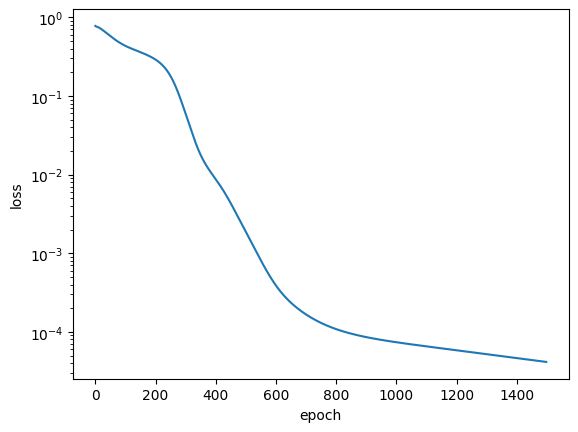

In [12]:
# plot loss
trainer_metrics = trainer.callbacks[0].metrics
loss = trainer_metrics["train_loss"]
epochs = range(len(loss))
plt.plot(epochs, loss.cpu())
# plotting
plt.xlabel("epoch")
plt.ylabel("loss")
plt.yscale("log")

## What's Next?

Congratulations on completing the introductory tutorial on Physics-Informed Training! Now that you have a solid foundation, here are several exciting directions you can explore:

1. **Experiment with Training Duration & Network Architecture**: Try different training durations and tweak the network architecture to optimize performance.

2. **Explore Other Models in `pina.model`**: Check out other models available in `pina.model` or design your own custom PyTorch module to suit your needs.

3. **Run Training on a GPU**: Speed up your training by running on a GPU and compare the performance improvements.

4. **Test Various Solvers**: Explore and evaluate different solvers to assess their performance on various types of problems.

5. **... and many more!**: The possibilities are vast! Continue experimenting with advanced configurations, solvers, and other features in PINA.

For more resources and tutorials, check out the [PINA Documentation](https://mathlab.github.io/PINA/).